In [ ]:
### Run this cell to import visualkeras ###
#!pip install visualkeras

In [ ]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.layers as layers
import visualkeras

from collections import defaultdict
from PIL import ImageFont
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping

# Data Loading

In [ ]:
# connect to google drive
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_clean_data = "Image Numpys_saved/"

# load data
X_train = np.load(folder_clean_data + 'X_train_resampled.npy')
y_train = np.load(folder_clean_data + 'y_train_resampled.npy')
X_val = np.load(folder_clean_data + 'X_val_resampled.npy')
y_val = np.load(folder_clean_data + 'y_val_resampled.npy')
X_test = np.load(folder_clean_data + 'X_test_pix.npy')
y_test = np.load(folder_clean_data + 'y_test.npy')

In [ ]:
# check the size of the train, validation and test set
print(f"""
X train shape: {X_train.shape}
y train shape: {y_train.shape}
X validation shape: {X_val.shape}
y validation shape: {y_val.shape}
X test shape: {X_test.shape}
y test shape: {y_test.shape}
""")


X train shape: (6043, 128, 128, 3)
y train shape: (6043,)
X validation shape: (2042, 128, 128, 3)
y validation shape: (2042,)
X test shape: (1491, 128, 128, 3)
y test shape: (1491,)



In [ ]:
# print value counts for train, validation and test set
unique_train, counts_train = np.unique(y_train, return_counts=True)
print(f"Value counts train: {dict(zip(unique_train, counts_train))}")
unique_val, counts_val = np.unique(y_val, return_counts=True)
print(f"Value counts validation: {dict(zip(unique_val, counts_val))}")
unique_test, counts_test = np.unique(y_test, return_counts=True)
print(f"Value counts test: {dict(zip(unique_test, counts_test))}")

Value counts train: {0: 3043, 1: 3000}
Value counts validation: {0: 1042, 1: 1000}
Value counts test: {0: 491, 1: 1000}


# Augmentation

In [ ]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    )

# Create generators for training and validation data
train_generator = datagen.flow(
    x= X_train,
    y= y_train,
    batch_size=32
)

val_generator = datagen.flow(
    x= X_val,
    y= y_val,
    batch_size=32
)

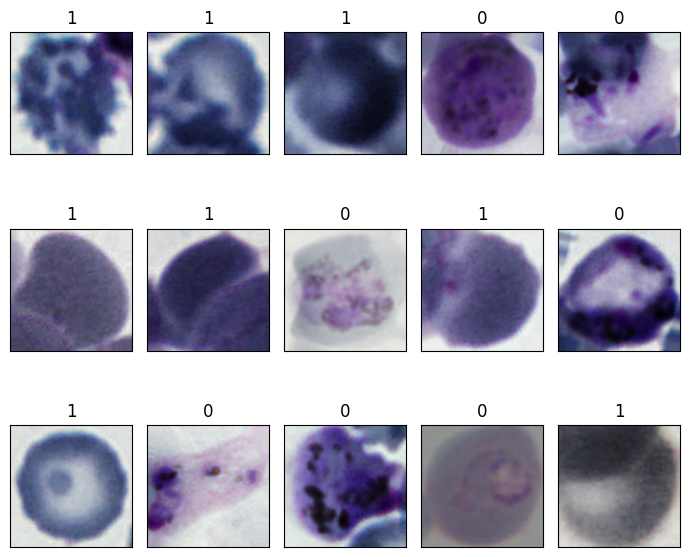

In [ ]:
# plot some of the augmented images
fig = plt.figure(figsize=(7,10))

x, y = train_generator.next()
for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x[i])
    plt.title(y[i])
    plt.xticks(())
    plt.yticks(())

plt.tight_layout()

# CNN

In [ ]:
# model 1
model1 = Sequential([
  layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=X_train.shape[1:4]),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(32, (3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(64, (3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.2),
  layers.Conv2D(64, (3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(128, (3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(2,2),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(1, activation='sigmoid')
])

# model 2
model2 = Sequential([
    layers.Conv2D(32, (5,5), activation='relu', input_shape=X_train.shape[1:4]),
    layers.Conv2D(32, (7,7), activation='relu'), # change from (5,5) due to the larger image size
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (5,5), activation='relu'),
    #layers.Conv2D(64, (3,3)), # remove do to unability to learn
    layers.AveragePooling2D(pool_size=(3, 3)),
    layers.Conv2D(128, (5,5), activation='relu'),
    #layers.Conv2D(256, (4,4)), # remove do to unability to learn
    layers.Flatten(),
    layers.Dense(256),
    layers.Dense(256),
    layers.Dense(1, activation='sigmoid')
])

model1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 conv2d_6 (Conv2D)           (None, 118, 118, 32)      50208     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 55, 55, 64)        51264     
                                                                 
 average_pooling2d (AverageP  (None, 18, 18, 64)       0         
 ooling2D)                                                       
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 128)      

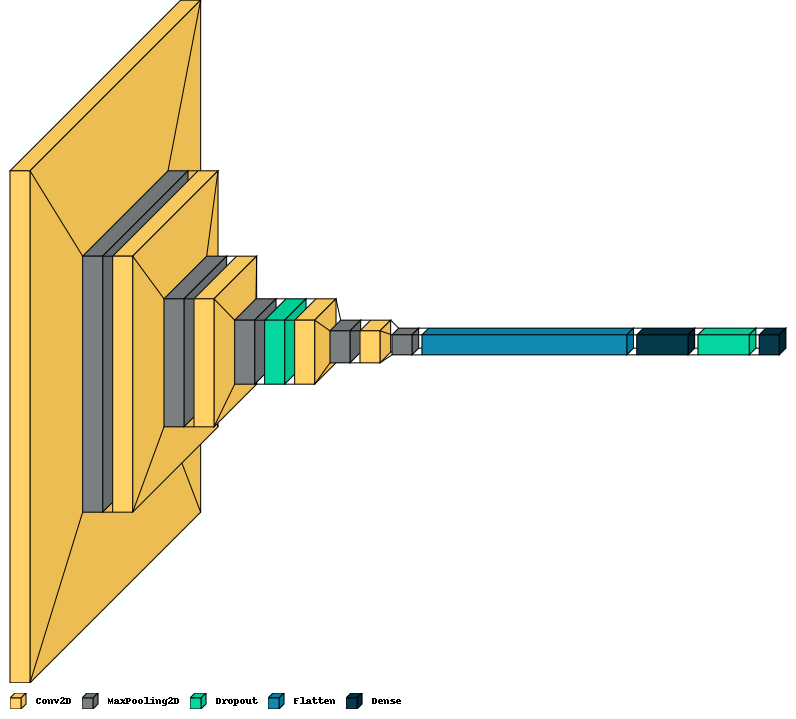

In [ ]:
# change the colors of the visualization
color_map = defaultdict(dict)
color_map[layers.MaxPooling2D]['fill'] = '#7a8082'

# display the architecture of the first model
visualkeras.layered_view(model1, legend=True, to_file="model1_architecture.png", color_map=color_map)

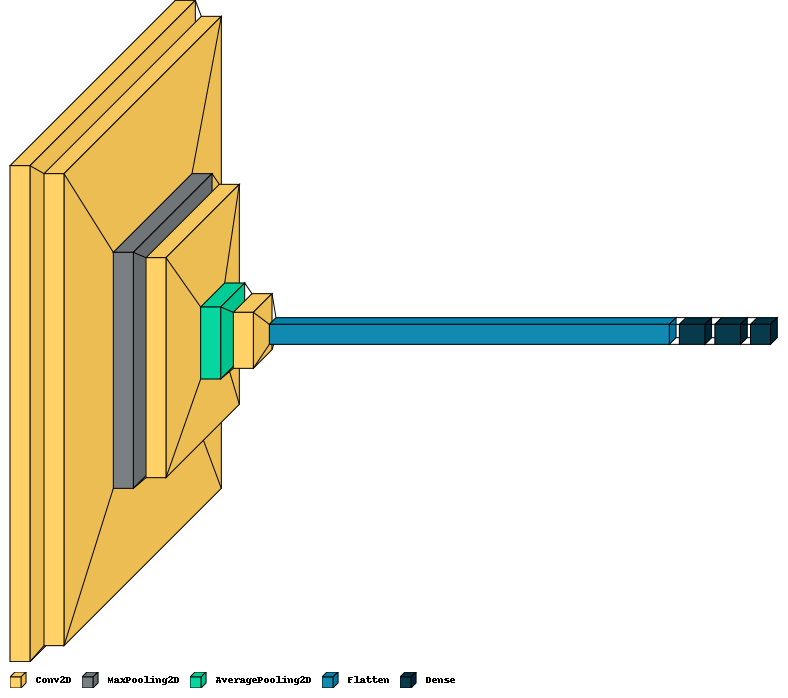

In [ ]:
# display the architecture of the second model
visualkeras.layered_view(model2, legend=True, to_file="model2_architecture.png", color_map=color_map)

In [ ]:
early_stopping = EarlyStopping(patience=7, min_delta=0.001, restore_best_weights=True)

In [ ]:
%%time
# Train the model
history1 = model1.fit(
    train_generator,
    steps_per_epoch=len(X_train)//32,
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(X_val)//32,
    batch_size = 64,
    callbacks=[early_stopping])

Epoch 1/50
188/188 [==============================] - 33s 148ms/step - loss: 0.4258 - accuracy: 0.7960 - val_loss: 0.2418 - val_accuracy: 0.9162
Epoch 2/50
188/188 [==============================] - 28s 147ms/step - loss: 0.2076 - accuracy: 0.9223 - val_loss: 0.1655 - val_accuracy: 0.9449
Epoch 3/50
188/188 [==============================] - 27s 145ms/step - loss: 0.1449 - accuracy: 0.9488 - val_loss: 0.1939 - val_accuracy: 0.9325
Epoch 4/50
188/188 [==============================] - 27s 143ms/step - loss: 0.1372 - accuracy: 0.9504 - val_loss: 0.1113 - val_accuracy: 0.9688
Epoch 5/50
188/188 [==============================] - 27s 144ms/step - loss: 0.1146 - accuracy: 0.9611 - val_loss: 0.1537 - val_accuracy: 0.9559
Epoch 6/50
188/188 [==============================] - 27s 145ms/step - loss: 0.0911 - accuracy: 0.9696 - val_loss: 0.1421 - val_accuracy: 0.9544
Epoch 7/50
188/188 [==============================] - 27s 145ms/step - loss: 0.0886 - accuracy: 0.9684 - val_loss: 0.0864 - val_ac

In [ ]:
%%time
# Train the model
history2 = model2.fit(
    train_generator,
    steps_per_epoch=len(X_train)//32,
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(X_val)//32,
    batch_size = 64,
    callbacks=[early_stopping])

Epoch 1/50
188/188 [==============================] - 35s 160ms/step - loss: 0.6326 - accuracy: 0.6663 - val_loss: 0.4305 - val_accuracy: 0.8095
Epoch 2/50
188/188 [==============================] - 29s 155ms/step - loss: 0.4223 - accuracy: 0.8170 - val_loss: 0.4160 - val_accuracy: 0.8259
Epoch 3/50
188/188 [==============================] - 28s 151ms/step - loss: 0.4042 - accuracy: 0.8212 - val_loss: 0.3901 - val_accuracy: 0.8413
Epoch 4/50
188/188 [==============================] - 29s 154ms/step - loss: 0.3007 - accuracy: 0.8794 - val_loss: 0.2228 - val_accuracy: 0.9172
Epoch 5/50
188/188 [==============================] - 28s 150ms/step - loss: 0.2746 - accuracy: 0.9007 - val_loss: 0.2392 - val_accuracy: 0.9092
Epoch 6/50
188/188 [==============================] - 28s 149ms/step - loss: 0.2265 - accuracy: 0.9158 - val_loss: 0.3030 - val_accuracy: 0.9008
Epoch 7/50
188/188 [==============================] - 28s 147ms/step - loss: 0.2031 - accuracy: 0.9281 - val_loss: 0.1994 - val_ac

In [ ]:
def plot_loss_accuracy(history):

    with plt.style.context('seaborn-deep'):

        fig, ax = plt.subplots(1, 2, figsize=(15, 4))

        ## Plot the loss curve and accuracy
        x_axis = np.arange(len(history.history['loss']))

        ax[0].set_title("Loss")
        ax[0].plot(x_axis, history.history['loss'], color="blue", linestyle=":", marker="X", label="Train Loss")
        ax[0].plot(x_axis, history.history['val_loss'], color="orange", linestyle="-", marker="X", label="Val Loss")

        ax[1].set_title("Accuracy")
        ax[1].plot(x_axis, history.history['accuracy'], color="blue", linestyle=":", marker="X", label="Train Accuracy")
        ax[1].plot(x_axis, history.history['val_accuracy'], color="orange", linestyle="-", marker="X", label="Val Accuracy")

        # customize the plot
        ax[0].grid(axis="x", linewidth=0.5)
        ax[0].grid(axis="y", linewidth=0.5)
        ax[0].legend()
        ax[1].grid(axis="x", linewidth=0.5)
        ax[1].grid(axis="y", linewidth=0.5)
        ax[1].legend()

        plt.show()

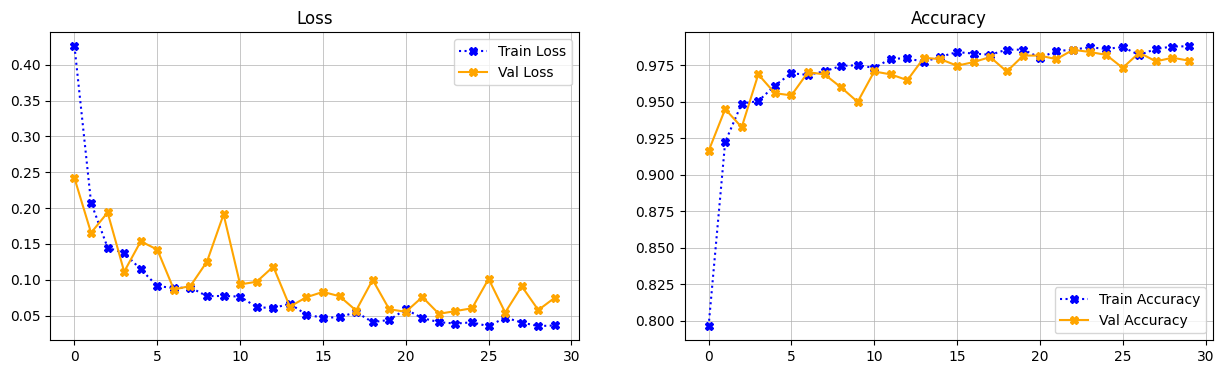

In [ ]:
# plot the history of model 1
plot_loss_accuracy(history1)

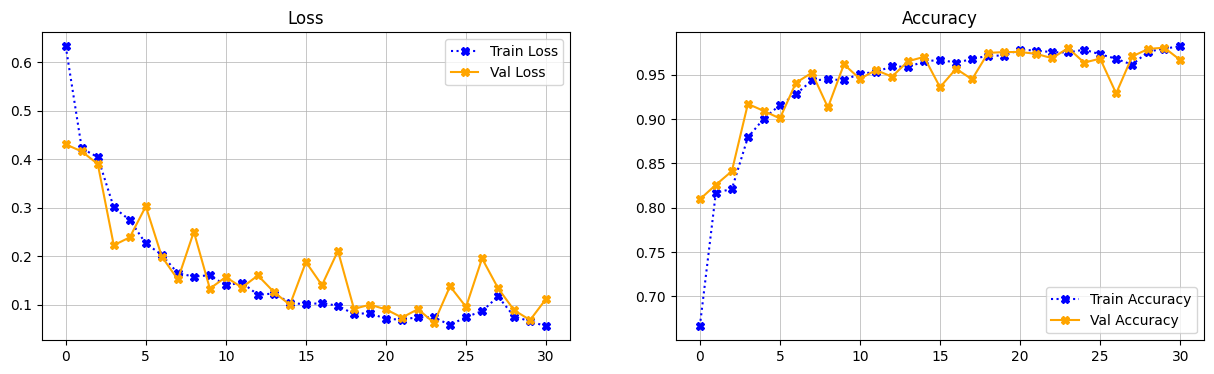

In [ ]:
# plot the history of model 2
plot_loss_accuracy(history2)

In [ ]:
### run this cell to save the models ###
#model1.save('/Models/CNN1')
#model2.save('/Models/CNN2')

# Evaluate the model on the test set

In [ ]:
### run this cell to load the models ###
model1 = load_model('Models/CNN1')
model2 = load_model('Models/CNN2')

## CNN 1

In [ ]:
loss, accuracy = model1.evaluate(X_test, y_test, verbose=1)
loss_v, accuracy_v = model1.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

64/64 [==============================] - 1s 8ms/step - loss: 0.0485 - accuracy: 0.9858
Validation: accuracy = 0.985798  ;  loss_v = 0.048514
Test: accuracy = 0.982562  ;  loss = 0.054641


In [ ]:
y_pred_model1 = model1.predict(X_test)

# Access the associated confusion matrix
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_model1.round()))

# Print performance measures  
print('Accuracy (simple):', accuracy_score(y_test, y_pred_model1.round()))
measures_info_model1 = classification_report(y_test, y_pred_model1.round())
print('Accuracy (extended):\n' + measures_info_model1)

47/47 [==============================] - 0s 5ms/step
Confusion Matrix:
 [[484   7]
 [ 19 981]]
Accuracy (simple): 0.9825620389000671
Accuracy (extended):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       491
           1       0.99      0.98      0.99      1000

    accuracy                           0.98      1491
   macro avg       0.98      0.98      0.98      1491
weighted avg       0.98      0.98      0.98      1491



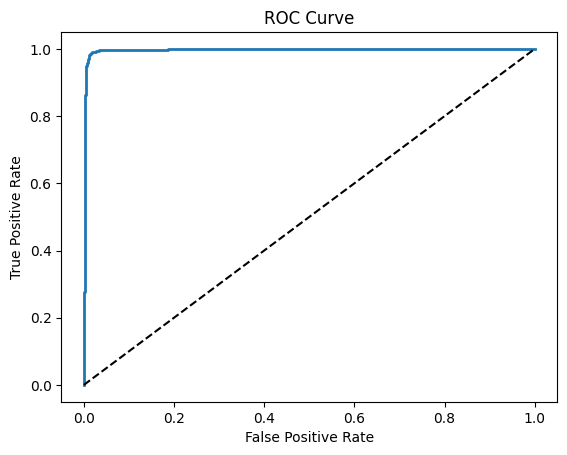

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_model1.ravel())

# plot the roc curve
def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--') # add the diagonal line
    plt.title("ROC Curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc(fpr, tpr)
plt.show()

## CNN 2

In [ ]:
loss, accuracy = model2.evaluate(X_test, y_test, verbose=1)
loss_v, accuracy_v = model2.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

64/64 [==============================] - 1s 22ms/step - loss: 0.0802 - accuracy: 0.9726
Validation: accuracy = 0.972576  ;  loss_v = 0.080234
Test: accuracy = 0.977197  ;  loss = 0.097970


In [ ]:
y_pred_model2 = model2.predict(X_test)

# Access the associated confusion matrix
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_model2.round()))

# Print performance measures  
print('Accuracy (simple):', accuracy_score(y_test, y_pred_model2.round()))
measures_info_model2 = classification_report(y_test, y_pred_model2.round())
print('Accuracy (extended):\n' + measures_info_model2)

47/47 [==============================] - 1s 11ms/step
Confusion Matrix:
 [[479  12]
 [ 22 978]]
Accuracy (simple): 0.97719651240778
Accuracy (extended):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       491
           1       0.99      0.98      0.98      1000

    accuracy                           0.98      1491
   macro avg       0.97      0.98      0.97      1491
weighted avg       0.98      0.98      0.98      1491



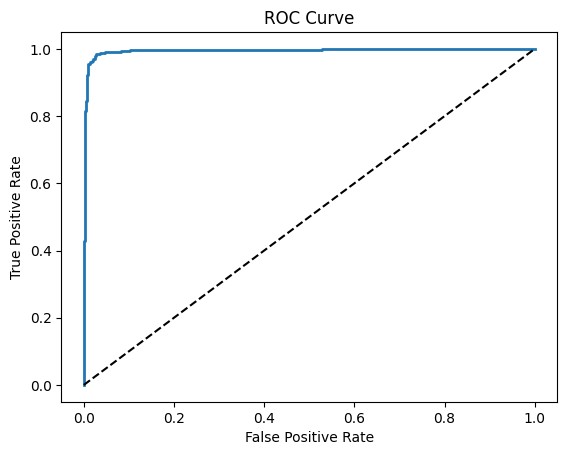

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_model2.ravel())
plot_roc(fpr, tpr)
plt.show()

# Error Analysis

In [ ]:
model1 = load_model('Models/CNN1')

In [ ]:
y_pred_model1 = model1.predict(X_test)

47/47 [==============================] - 7s 8ms/step


In [ ]:
# define a function that shows images of wrong classified images
def plot_misclassified_images(X_test, y_test, y_pred):
    
    misclassified_indices = np.where(np.squeeze(y_pred.round())!=y_test)[0]
    
    num_images = min(7, len(misclassified_indices))
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i, idx in enumerate(misclassified_indices[:num_images]):
        img = X_test[idx]

        axes[i].imshow(img)
        axes[i].set_title(f'{idx} True: {y_test[idx]}\nPredicted: {y_pred[idx]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

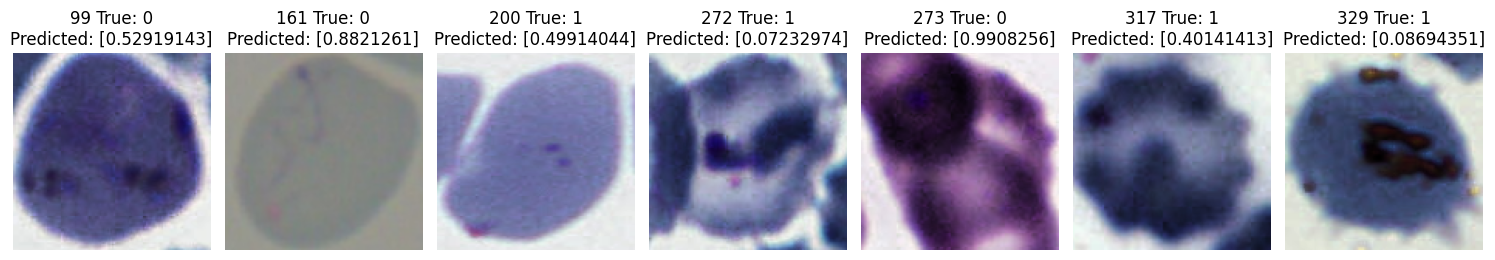

In [ ]:
plot_misclassified_images(X_test, y_test, y_pred_model1)

# Example CNN model 1 and 2 without Augmentation

In [ ]:
# model 1
model1_noaug = Sequential([
  layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=X_train.shape[1:4]),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(32, (3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(64, (3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.2),
  layers.Conv2D(64, (3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(128, (3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(2,2),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(1, activation='sigmoid')
])

# model 2
model2_noaug = Sequential([
    layers.Conv2D(32, (5,5), activation='relu', input_shape=X_train.shape[1:4]),
    layers.Conv2D(32, (7,7), activation='relu'), # change from (5,5) due to the larger image size
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (5,5), activation='relu'),
    #layers.Conv2D(64, (3,3)), # remove do to unability to learn
    layers.AveragePooling2D(pool_size=(3, 3)),
    layers.Conv2D(128, (5,5), activation='relu'),
    #layers.Conv2D(256, (4,4)), # remove do to unability to learn
    layers.Flatten(),
    layers.Dense(256),
    layers.Dense(256),
    layers.Dense(1, activation='sigmoid')
])

model1_noaug.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model2_noaug.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
%%time
# Train the model
history1_noaug = model1_noaug.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    batch_size = 64,
    callbacks=[early_stopping])

Epoch 1/50
95/95 [==============================] - 15s 41ms/step - loss: 0.6373 - accuracy: 0.6159 - val_loss: 0.3891 - val_accuracy: 0.8452
Epoch 2/50
95/95 [==============================] - 3s 26ms/step - loss: 0.3152 - accuracy: 0.8772 - val_loss: 0.2345 - val_accuracy: 0.9202
Epoch 3/50
95/95 [==============================] - 3s 27ms/step - loss: 0.1899 - accuracy: 0.9343 - val_loss: 0.1926 - val_accuracy: 0.9231
Epoch 4/50
95/95 [==============================] - 3s 27ms/step - loss: 0.1293 - accuracy: 0.9548 - val_loss: 0.1166 - val_accuracy: 0.9638
Epoch 5/50
95/95 [==============================] - 3s 28ms/step - loss: 0.1056 - accuracy: 0.9618 - val_loss: 0.1609 - val_accuracy: 0.9368
Epoch 6/50
95/95 [==============================] - 3s 27ms/step - loss: 0.0881 - accuracy: 0.9719 - val_loss: 0.1143 - val_accuracy: 0.9691
Epoch 7/50
95/95 [==============================] - 3s 28ms/step - loss: 0.0665 - accuracy: 0.9762 - val_loss: 0.0975 - val_accuracy: 0.9696
Epoch 8/50
9

In [ ]:
%%time
# Train the model
history1_noaug = model1_noaug.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    batch_size = 64,
    callbacks=[early_stopping])

Epoch 1/50
95/95 [==============================] - 15s 102ms/step - loss: 0.6087 - accuracy: 0.7088 - val_loss: 0.3672 - val_accuracy: 0.8516
Epoch 2/50
95/95 [==============================] - 6s 64ms/step - loss: 0.3372 - accuracy: 0.8552 - val_loss: 0.3784 - val_accuracy: 0.8482
Epoch 3/50
95/95 [==============================] - 6s 65ms/step - loss: 0.3068 - accuracy: 0.8785 - val_loss: 0.3532 - val_accuracy: 0.8634
Epoch 4/50
95/95 [==============================] - 6s 65ms/step - loss: 0.2775 - accuracy: 0.8888 - val_loss: 0.3304 - val_accuracy: 0.8643
Epoch 5/50
95/95 [==============================] - 6s 65ms/step - loss: 0.2350 - accuracy: 0.9149 - val_loss: 0.3255 - val_accuracy: 0.8570
Epoch 6/50
95/95 [==============================] - 6s 65ms/step - loss: 0.2414 - accuracy: 0.9077 - val_loss: 0.2345 - val_accuracy: 0.9109
Epoch 7/50
95/95 [==============================] - 6s 64ms/step - loss: 0.1557 - accuracy: 0.9441 - val_loss: 0.1813 - val_accuracy: 0.9358
Epoch 8/50


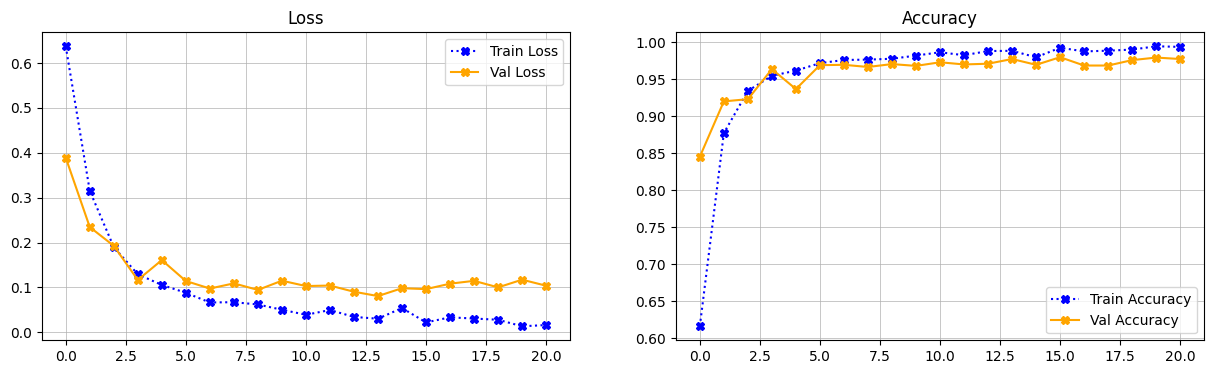

In [ ]:
# plot the history of model 1
plot_loss_accuracy(history1_noaug)

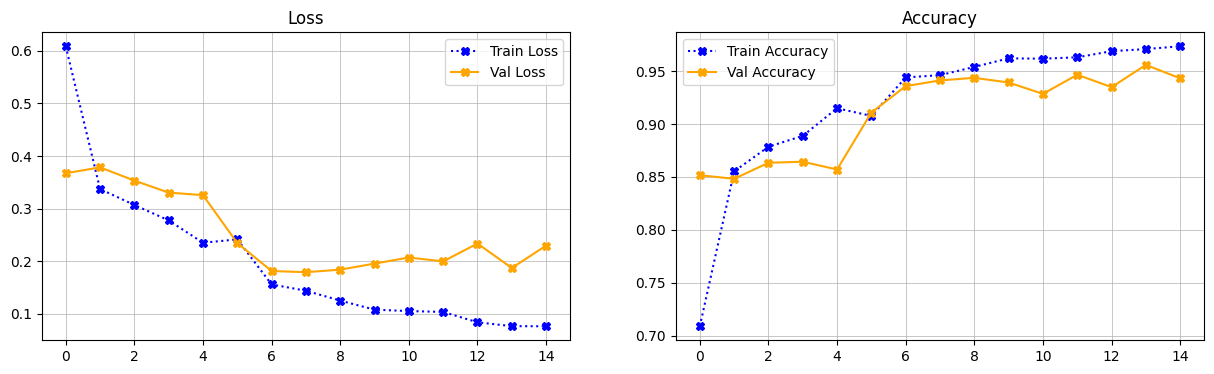

In [ ]:
# plot the history of model 2
plot_loss_accuracy(history2_noaug)

## Evaluation CNN 1 no augmentation

In [ ]:
loss, accuracy = model1_noaug.evaluate(X_test, y_test, verbose=1)
loss_v, accuracy_v = model1_noaug.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

64/64 [==============================] - 0s 7ms/step - loss: 0.0808 - accuracy: 0.9775
Validation: accuracy = 0.977473  ;  loss_v = 0.080790
Test: accuracy = 0.976526  ;  loss = 0.104290


In [ ]:
y_pred_model1_noaug = model1_noaug.predict(X_test)

# Access the associated confusion matrix
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_model1_noaug.round()))

# Print performance measures  
print('Accuracy (simple):', accuracy_score(y_test, y_pred_model1_noaug.round()))
measures_info_model1_aug = classification_report(y_test, y_pred_model1_noaug.round())
print('Accuracy (extended):\n' + measures_info_model1_aug)

47/47 [==============================] - 0s 5ms/step
Confusion Matrix:
 [[477  14]
 [ 21 979]]
Accuracy (simple): 0.9765258215962441
Accuracy (extended):
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       491
           1       0.99      0.98      0.98      1000

    accuracy                           0.98      1491
   macro avg       0.97      0.98      0.97      1491
weighted avg       0.98      0.98      0.98      1491



## Evaluation CNN 2 without augmentation

In [ ]:
loss, accuracy = model2_noaug.evaluate(X_test, y_test, verbose=1)
loss_v, accuracy_v = model2_noaug.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

64/64 [==============================] - 1s 20ms/step - loss: 0.1790 - accuracy: 0.9412
Validation: accuracy = 0.941234  ;  loss_v = 0.179040
Test: accuracy = 0.930248  ;  loss = 0.208770


In [ ]:
y_pred_model2_noaug = model2_noaug.predict(X_test)

# Access the associated confusion matrix
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_model2_noaug.round()))

# Print performance measures  
print('Accuracy (simple):', accuracy_score(y_test, y_pred_model2_noaug.round()))
measures_info_model2_aug = classification_report(y_test, y_pred_model2_noaug.round())
print('Accuracy (extended):\n' + measures_info_model2_aug)

47/47 [==============================] - 0s 9ms/step
Confusion Matrix:
 [[477  14]
 [ 90 910]]
Accuracy (simple): 0.9302481556002683
Accuracy (extended):
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       491
           1       0.98      0.91      0.95      1000

    accuracy                           0.93      1491
   macro avg       0.91      0.94      0.92      1491
weighted avg       0.94      0.93      0.93      1491

